In [1]:
import numpy as np
import h5py
import time
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
def initialise_parameters(layer_dims):
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [4]:
def linear_activation_forward(A_prev,W,b,activation):
   
    Z,linear_cache = (np.dot(W,A_prev) + b ), (A_prev,W,b)
    if activation == "sigmoid":
        A = 1/(1+np.exp(-Z))
    elif activation == "relu":
        A = np.maximum(0,Z)
                                
    cache = (linear_cache, Z) 
   # print(cache)                             
    return  A,cache
   
                                 

In [5]:
def linear_forward_propogation(X,parameters):
    
    n = len(parameters)//2
    caches = []
    A = X
    
    for l in range(1,n):
        A,cache = linear_activation_forward(A,parameters['W'+str(l)],parameters['b'+str(l)],"relu")
        caches.append(cache)
    
    Al,cache = linear_activation_forward(A,parameters['W'+str(n)],parameters['b'+str(n)],"sigmoid")
    caches.append(cache)
    assert(Al.shape == (1,X.shape[1]))
    
    return Al,caches
    
    

In [6]:
def compute_cost(Al,Y):
    
    m = Y.shape[1]
    
    cost = -1/m*(np.sum(np.dot(Y,np.log(Al).T)+np.dot((1-Y),np.log(1-Al).T)))
    cost = np.squeeze(cost)
    
    return cost

In [7]:
def linear_backward(dZ,cache):
     
    A_prev,W,b = cache
    m = A_prev.shape[1]
    dW = 1/m*(np.dot(dZ,A_prev.T))
    db = 1/m*(np.sum(dZ,axis=1,keepdims = True))
    dA = np.dot(W.T,dZ)
    
    return dA,dW,db

In [8]:
def linear_activation_backward(dA,cache,activation):
    linear_cache,activation_cache = cache
    #print("iter::",dA.shape)
    if activation == "sigmoid":
        Z = activation_cache
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
        dA,dW,db = linear_backward(dZ,linear_cache)
    elif activation == "relu":
        Z = activation_cache
        dZ = np.array(dA, copy=True)
       
        dZ[Z <= 0] = 0
        assert (dZ.shape == Z.shape)
        dA,dW,db = linear_backward(dZ,linear_cache)
    
    return dA,dW,db     

In [9]:
def linear_backward_propogation(AL,Y,caches):
    
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads
    
    
    

In [10]:
def update_parameter(parameters,grads,learning_rate):
    
    n = len(parameters)//2
    
    for l in range(n):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    
    return parameters

In [11]:
train_Xorgi,train_Y,test_Xorgi,test_Y, classes  = load_data()

In [12]:
m = train_Xorgi.shape[0]
num_px = train_Xorgi.shape[1]
m_test = test_Xorgi.shape[0]
print("No of examples:::",m,"No of Pixel:::",num_px,"No of test images:::",m_test,"Y train:",train_Y.shape)

No of examples::: 209 No of Pixel::: 64 No of test images::: 50 Y train: (1, 209)


In [13]:
train_X = train_Xorgi.reshape(m,-1).T
test_X = test_Xorgi.reshape(m_test,-1).T

train_X = train_X/255
test_X = test_X/255

print(train_X.shape)


(12288, 209)


In [14]:
def l_model_deepNN(X,Y,layer_dims,learning_rate = 0.0075,num_iterations = 2500, print_cost=False):
    m = X.shape[1]
    np.random.seed(1)
    costs = [] 
    
    parameters = initialise_parameters(layer_dims)
    #print(parameters)
    
    for i in range(0,num_iterations):
        Al,cache = linear_forward_propogation(X,parameters)
        cost = compute_cost(Al,Y)
        #costs.append(cost)
        grads = linear_backward_propogation(Al,Y,cache)
        parameters = update_parameter(parameters,grads,learning_rate)
        if print_cost and i % 100 == 0:
             print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
        
    plt.plot(np.squeeze(costs))
    plt.ylabel("cost")
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
        
    return parameters
        

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


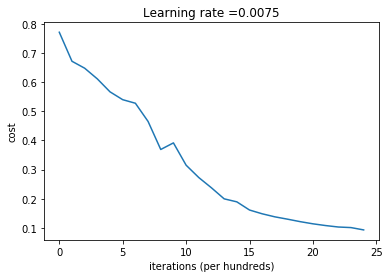

In [15]:
layers_dims = [12288, 20, 7, 5, 1]
parameters = l_model_deepNN(train_X,train_Y,layers_dims, num_iterations = 2500, print_cost = True)

In [16]:
def predict(X,Y,parameters):
    m = X.shape[1]
    n = len(parameters) //2
    p = np.zeros((1,m))
    probas,cache = linear_forward_propogation(X,parameters)
    #print(m,n,p,probos.shape)
    for i in range(0, m):
        if probas[0][i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("Accuracy: "  + str(np.sum((p == Y)/m)))
    return p

In [17]:
prediction_train = predict(train_X, train_Y, parameters)

Accuracy: 0.9856459330143539


In [18]:
prediction_test = predict(test_X,test_Y,parameters)

Accuracy: 0.8


In [19]:
def print_mislabeled_images(classes, X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


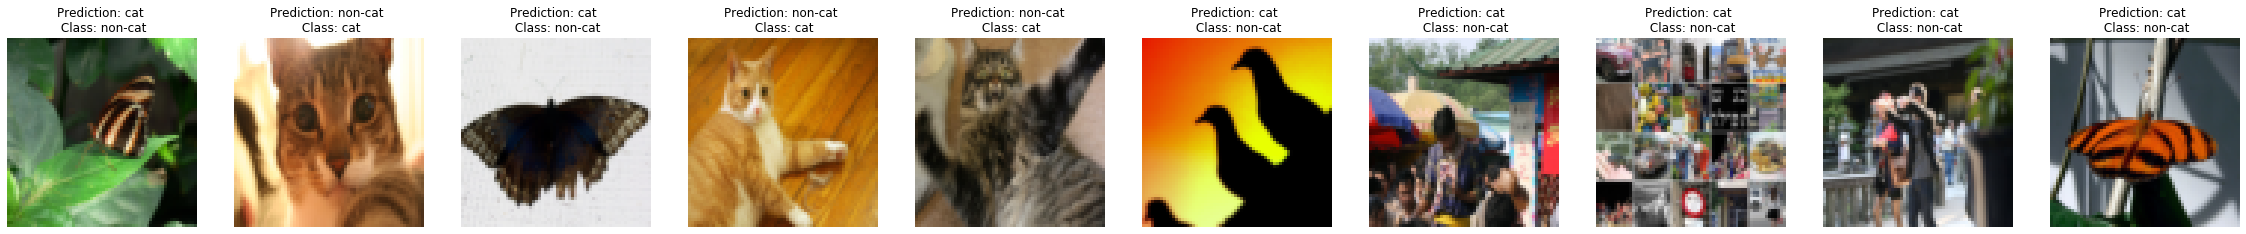

In [20]:
print_mislabeled_images(classes, test_X, test_Y, prediction_test)

(183, 275, 3)
(12288, 1)
Accuracy: 0.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


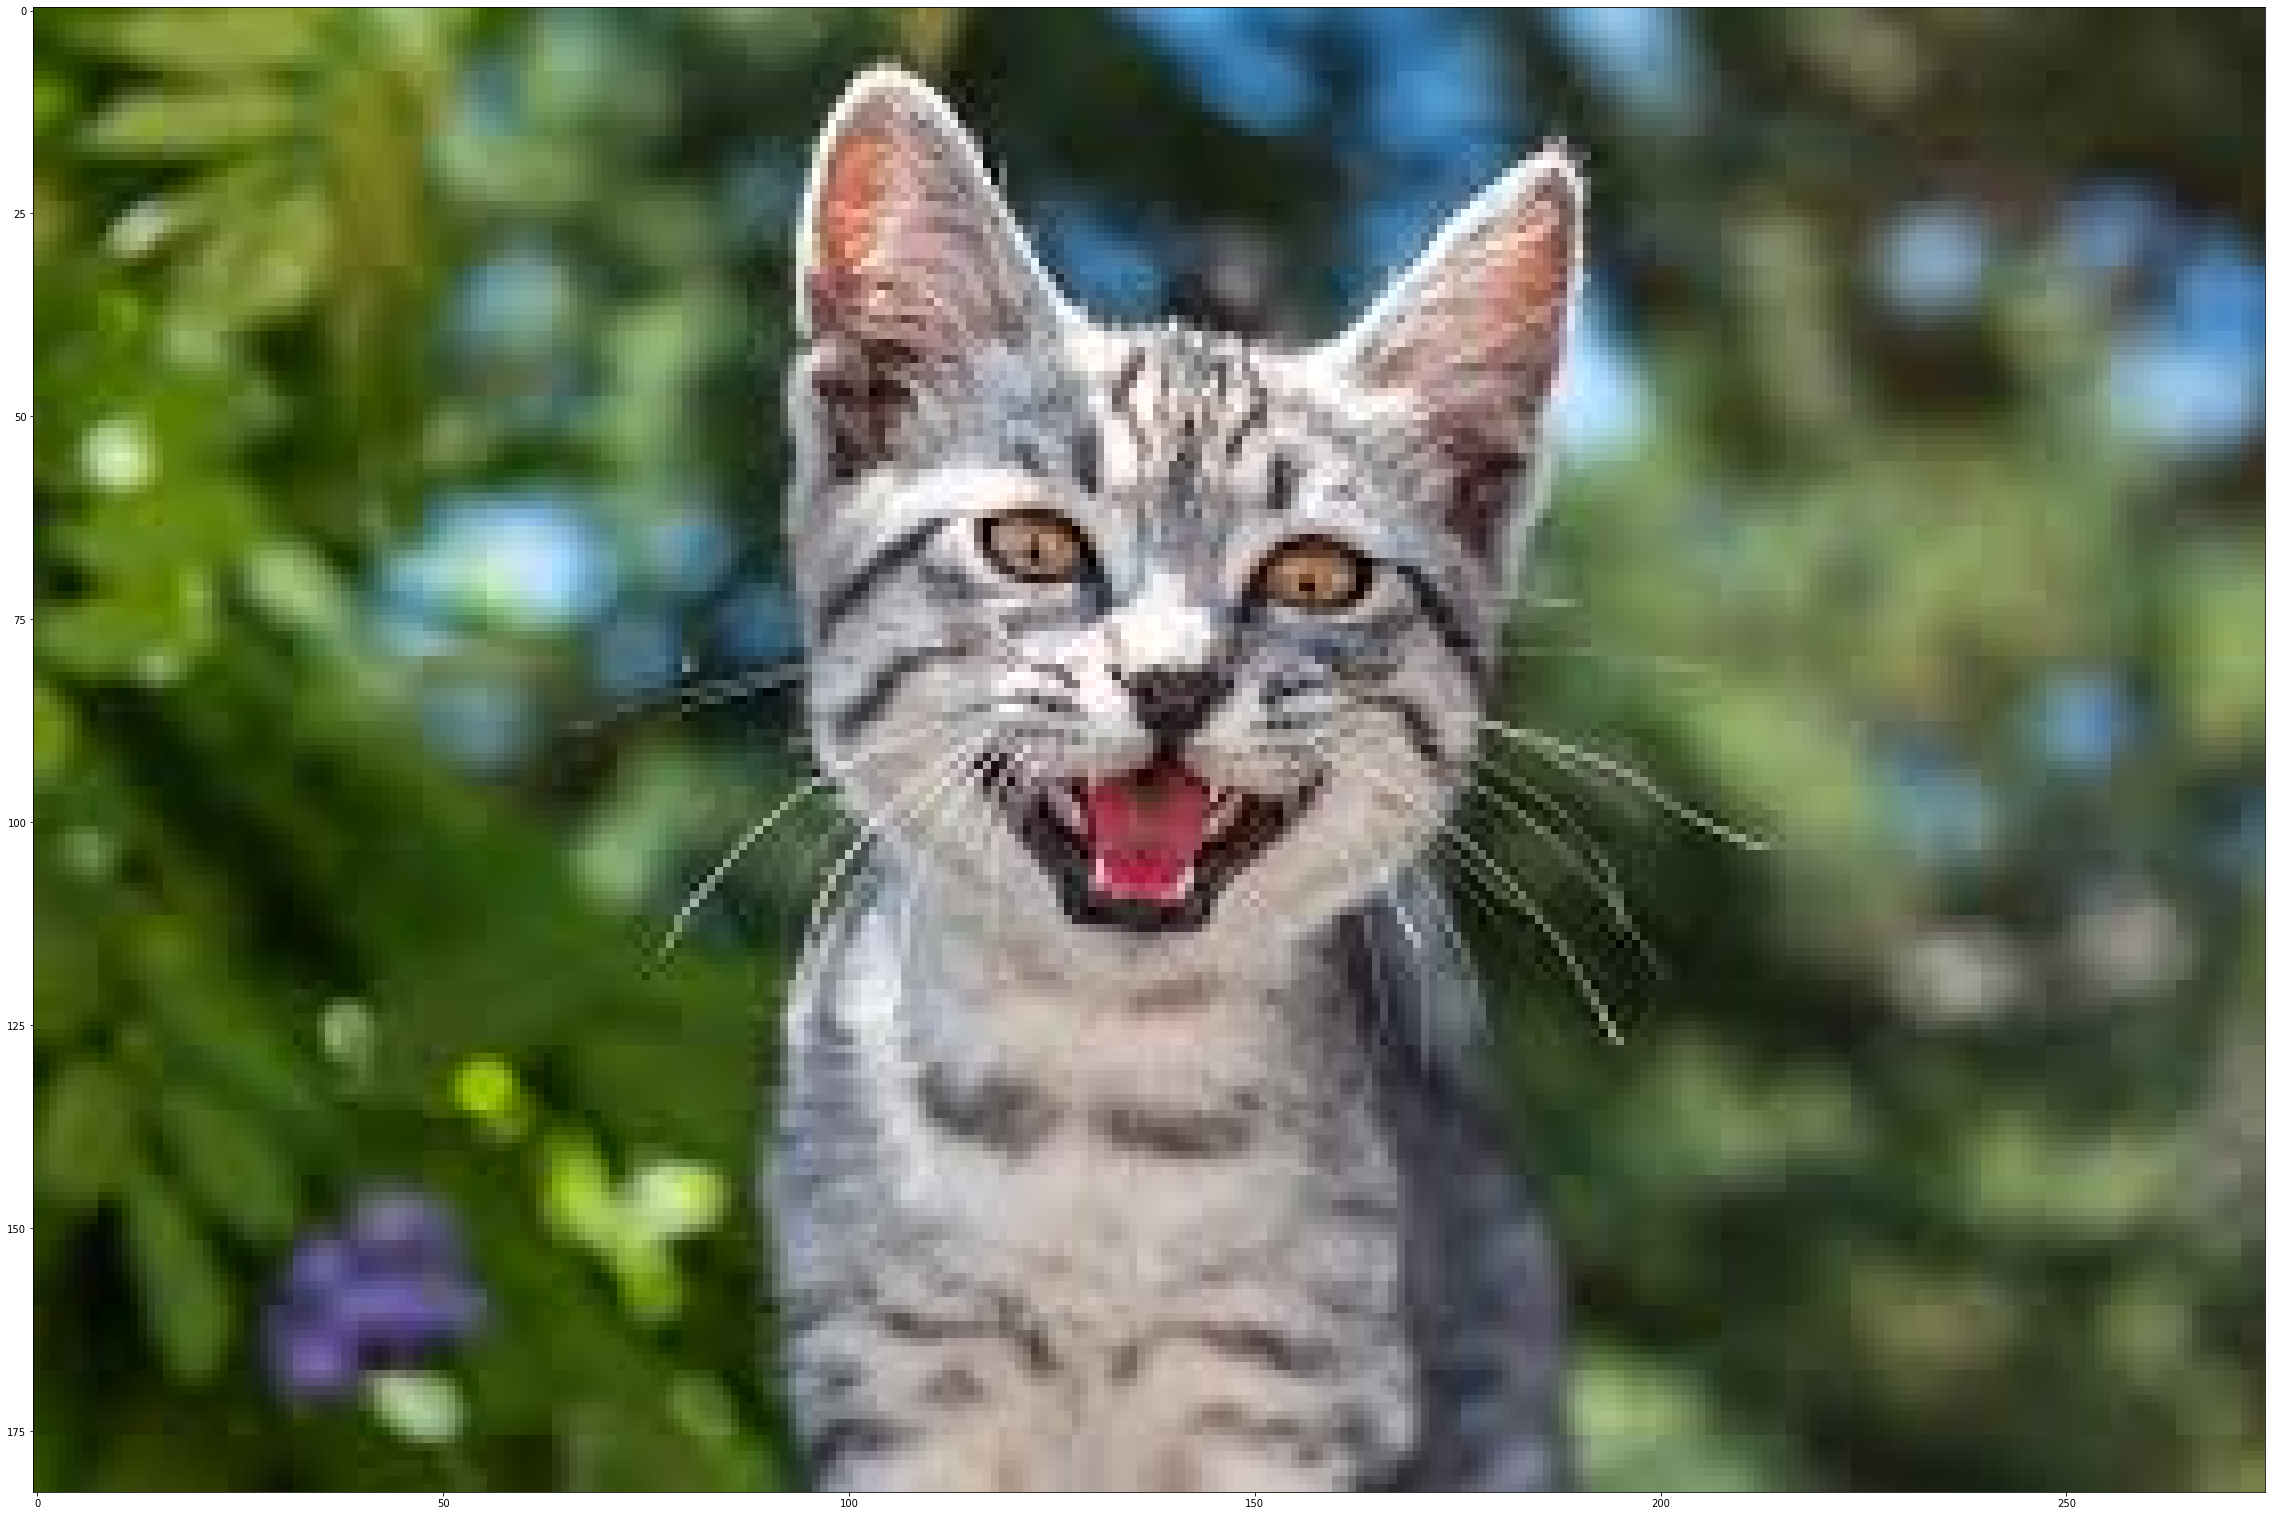

In [38]:
import cv2
import scipy.misc
from skimage.transform import resize
img = "images/download4.jpg"
label_Y = [1]
img_orgi = np.array(cv2.cvtColor((cv2.imread(img)),cv2.COLOR_BGR2RGB))
print(img_orgi.shape)
#img = scipy.misc.imresize(img,size=(num_px,num_px).reshape((num_px*num_px*3,1)))
img = cv2.resize(img_orgi,(num_px,num_px)).reshape(( 64 * 64 * 3,1))
#img = img.flatten
print(img.shape)
img = img/255
predict_img = predict(img,label_Y,parameters)
plt.imshow(img_orgi)
print ("y = " + str(np.squeeze(predict_img)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(predict_img)),].decode("utf-8") +  "\" picture.")